In [185]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)



In [109]:
df_train = pd.read_csv("../data/raw/train.csv",index_col=0)
df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
df_test["SalePrice"] = 0

df = pd.concat([df_train, df_test], sort=False)
df = df.drop("SalePrice", axis=1)

xx = df.duplicated()
xx[xx]

Id
2714    True
2866    True
dtype: bool

In [2]:
def load_test_train_data() :

    print("\n\n*****\nLoading test and train data....")
    df_train = pd.read_csv("../data/raw/train.csv",index_col=0)
    df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
    df_train["data_type"] = "train"
    df_test["data_type"] = "test"
    df_test["SalePrice"] = 0

    df = pd.concat([df_train, df_test], sort=False)
    df = df.reset_index(drop=True)

    print("Train Data Shape :", df_train.shape)
    print("Test Data Shape : ", df_test.shape)
    print("Combined Data Shape : ", df.shape)

    return (df_train, df_test, df)


In [3]:
def write_processed_files(df):
    
    print("\n\n*****\nGenerating processed data files...")

    train = df[df.data_type_train == 1].reset_index(drop=True)
    test = df[df.data_type_test == 1].reset_index(drop=True)    

    train.drop("data_type_train", axis=1, inplace=True)
    train.drop("data_type_test", axis=1, inplace=True)    
    test.drop("data_type_train", axis=1,inplace=True)
    test.drop("data_type_test", axis=1,inplace=True)
    test.drop("SalePrice", axis=1,inplace=True)
    
    df.to_csv("../data/processed_data/full_processed.csv")
    train.to_csv("../data/processed_data/train_processed.csv",index=False)
    test.to_csv("../data/processed_data/test_processed.csv", index=False)

    return None



In [4]:
def get_column_names_by_type(df):
    numeric_columns = df.describe().columns
    non_numeric_columns = [i for i in df.columns if i not in numeric_columns]
    return (numeric_columns, non_numeric_columns)
    

In [5]:
#missing value counter
def na_counter(data):
    coln = list(data.columns)

    if data.isnull().any().sum() == 0:
        return pd.DataFrame(columns=['NA Count',"PERCENT"])
    
    na_dict ={}
    for col in coln:
        if data[col].isnull().any()==True:
            na_count = data[col].isnull().sum()
            na_percent = data[col].isnull().sum()/len(data)
            na_dict[col]=[na_count, na_percent]
    df_na =pd.DataFrame(na_dict).T
    df_na.columns = ['NA Count',"PERCENT"]
    df_na.index.name = "Column"
    return df_na

In [6]:
def impute_null_fields(df):
    
    print("\n\n*****\nImputing Null values....")
    print("Null counts before imputing:")
    print(na_counter(df))
    

    """ ?? """
    df["MSZoning"] = df["MSZoning"].fillna("RM")
    df["LotFrontage"] = df["LotFrontage"].fillna(df.groupby("Neighborhood")["LotFrontage"].transform("mean"))
    df["MasVnrType"] = df["MasVnrType"].fillna("None") 
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0.0) 
    df["BsmtQual"] = df["BsmtQual"].fillna("NoBsmt")
    df["BsmtCond"] = df["BsmtCond"].fillna("NoBsmt")
    df["BsmtExposure"] = df["BsmtExposure"].fillna("NoBsmt")
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NoBsmt")
    df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NoBsmt")
    df['Exterior1st'] = df['Exterior1st'].fillna("None") 
    df['Exterior2nd'] = df['Exterior2nd'].fillna("None")
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0) 
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0) 
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0) 
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0) 
    

    """ Only one row missing the value, impute with "SBrkr" which is the most used """
    df.Electrical = df.Electrical.fillna("SBrkr")

    """ Impute with equavelant of overall house quality : Average, equivalent "TA" """
    df.KitchenQual = df.KitchenQual.fillna("None")

    df.FireplaceQu = df.FireplaceQu.fillna("None")
    
    """ First change Garage Type for row with Null area and then change Garage Area """
    df.loc[df.GarageArea.isnull(), "GarageType"] = np.nan
    df.loc[df.GarageArea.isnull(), "GarageArea"] = 0
    
        

    """ For one record with Garage Area 360 and with missing Garage values, set to average values based on Overall Quality """
    df.loc[(df.GarageArea==360) & df.GarageFinish.isnull(), "GarageFinish"] = "Unf"
    df.loc[(df.GarageArea==360) & df.GarageQual.isnull(), "GarageQual"] = "TA"
    df.loc[(df.GarageArea==360) & df.GarageCond.isnull(), "GarageCond"] = "TA"
    """ Setting the Garage built to "Year Remodelled" """
    df.loc[(df.GarageArea==360) & df.GarageYrBlt.isnull(), "GarageYrBlt"] = df.YearRemodAdd


    
    """ Set rest of the missing Garage valies to None and GarageCars to zero"""
    df.GarageFinish = df.GarageFinish.fillna("None")
    df.GarageQual = df.GarageQual.fillna("None")
    df.GarageCond = df.GarageCond.fillna("None")
    df.GarageType = df.GarageType.fillna("None")

    df.GarageCars = df.GarageCars.fillna(0)


    """ Is it correct to fill with Zero for Year built as the scale will change compared to most values in 1900""" 
    df.GarageYrBlt = df.GarageYrBlt.fillna(0)


    """ Impiute with Typ as mentioned in documentation. There does not seem to be clear relation with
        Overall quality fields
    """
    df.loc[df.Functional.isnull(), "Functional"] = "Typ"


    """Basement Fullbath and Halfbath NA values are related to  houses without basements. Soe set them to 0 """
    df.BsmtFullBath = df.BsmtFullBath.fillna(0)
    df.BsmtHalfBath = df.BsmtHalfBath.fillna(0)
    
    
    """ ?? """
    df['SaleType'] = df['SaleType'].fillna("Oth")
    df['GarageQual'] = df['GarageQual'].fillna("None")

    print("\n\n\nNull counts after imputing:")
    print(na_counter(df))

    return df

In [7]:
def correct_data(df):
    
    print("\n\n*****\nCorrecting incorrect data values...")

    """Seems the year is 2207 is a typo, setting to the year remodeled"""
    df.loc[df.GarageYrBlt==2207, "GarageYrBlt"] = 2007
    return df

In [8]:

def transform_ordinal(df):
    typical_graded_cols = ["HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "ExterQual",
                          "ExterCond", "BsmtQual", "BsmtCond"]
    typical_grade_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

    for i in typical_graded_cols:
        df[i].replace(typical_grade_map, inplace=True)
    
    df['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
    df['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
    
    return df

In [9]:
def drop_columns(df):
    
    print("\n\n*****\nDropping selective columns...")
    columsn_to_drop = ["Street", "Alley","Utilities","Condition2", "RoofMatl", "LowQualFinSF","GarageYrBlt",
                       "GarageQual", "PoolQC","Fence","MiscFeature", "GarageCond","MiscVal"]

    columsn_to_drop = columsn_to_drop + ["MoSold", "YrSold"]
    
    print("\n\n*****\nNo of columns before dropping : ", len(df.columns))
    print("No of columns to drop : ", len(columsn_to_drop))
    
    df.drop(columsn_to_drop, axis=1, inplace=True)
    print("No of columns after dropping : ", len(df.columns))

    return df

In [10]:
def value_counts(data, kind="non-numeric", threshold = 15): 
    
    continuous_col = data.describe().columns
    categorical_col =data.drop(continuous_col, axis=1).columns
    
    if (kind=="non-numeric"):
        columns = categorical_col
    elif (kind == "numeric"):
        columns = continuous_col
    else :
        columns = data.columns
    
    for col in (columns):
        if (len(data[col].value_counts())<= threshold):
            print(data[col].value_counts())
            print("")

In [11]:
def print_data_stats(df):
    print("\n\n*****\nPrinting stats...")
    print("No of rows : ", df.shape[0])
    print("No of columns : ", df.shape[1])
    
    x,y = get_column_names_by_type(df)
    print("Numeric columns : ", len(x))
    print("Non Numeric columns : ", len(y))
    
    print("\n\nNull counts :")
    print(na_counter(df))
    
    return df

In [12]:
def change_column_type(df):
    
    print("\n\n*****\n Changing some columns to category ...")
    df.MSSubClass = df.MSSubClass.astype("category")    
    return df

In [13]:
def standardize_features(df):

    print("\n\n*****\n Standardizing numeric columns ...")
    sclr = StandardScaler()
    num_cols, cat_cols = get_column_names_by_type(df)
    num_cols = num_cols.drop("SalePrice")
    
    
    df2 = sclr.fit_transform(df[num_cols])
    df.loc[:,num_cols] = df2

    return df

In [23]:
def process_raw_data(standardize = True, use_ordinal=False):
    
    print("\n\n*****\n Processing raw files to generate processed files... hold tight...")
    train_df, test_df, full_df = load_test_train_data()
    
    final_df = full_df.copy().\
        pipe(print_data_stats).\
        pipe(impute_null_fields).\
        pipe(correct_data)
#     .\
#         pipe(change_column_type)
# #     .\
#         pipe(drop_columns)
    
    if (use_ordinal):
        final_df = transform_ordinal(final_df)

#     if (standardize):
#         final_df = standardize_features(final_df)
        
#     final_df = final_df.pipe(pd.get_dummies).\
#             pipe(print_data_stats).\
#             pipe(write_processed_files)

    return(train_df, test_df, full_df,final_df)
    

In [198]:
train,test,all_df,fin_df = process_raw_data()



*****
 Processing raw files to generate processed files... hold tight...


*****
Loading test and train data....
Train Data Shape : (1460, 81)
Test Data Shape :  (1459, 81)
Combined Data Shape :  (2919, 81)


*****
Printing stats...
No of rows :  2919
No of columns :  81
Numeric columns :  37
Non Numeric columns :  44


Null counts :
              NA Count   PERCENT
Column                          
MSZoning           4.0  0.001370
LotFrontage      486.0  0.166495
Alley           2721.0  0.932169
Utilities          2.0  0.000685
Exterior1st        1.0  0.000343
Exterior2nd        1.0  0.000343
MasVnrType        24.0  0.008222
MasVnrArea        23.0  0.007879
BsmtQual          81.0  0.027749
BsmtCond          82.0  0.028092
BsmtExposure      82.0  0.028092
BsmtFinType1      79.0  0.027064
BsmtFinSF1         1.0  0.000343
BsmtFinType2      80.0  0.027407
BsmtFinSF2         1.0  0.000343
BsmtUnfSF          1.0  0.000343
TotalBsmtSF        1.0  0.000343
Electrical         1.0  0.000343
Bs

In [37]:
num_cols,cat_cols =  get_column_names_by_type(all_df)

In [38]:
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

    

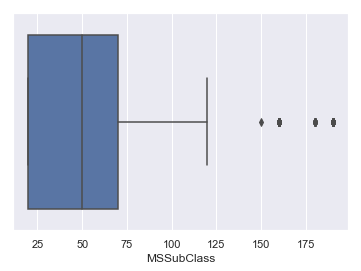

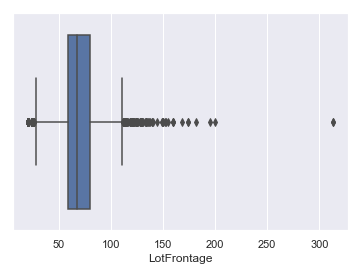

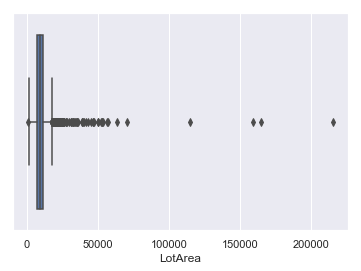

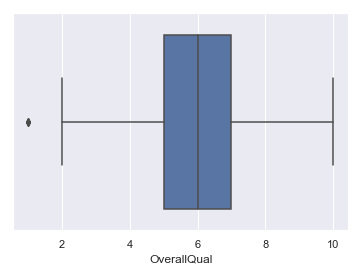

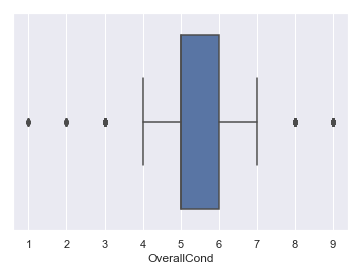

In [40]:
for i in ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']:
#        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
#        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
#        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()


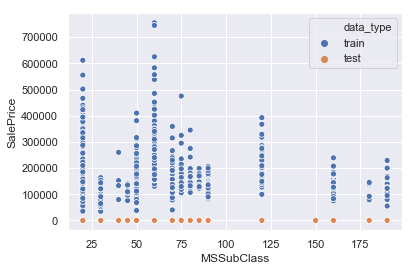

In [121]:
sns.scatterplot(all_df.MSSubClass, all_df.SalePrice,hue=all_df.data_type)

In [42]:
all_df.MSSubClass.value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

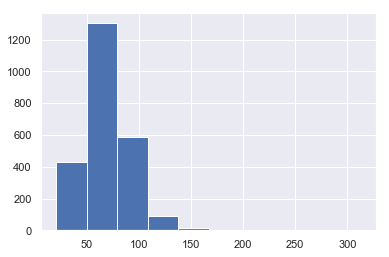

In [49]:
all_df.LotFrontage.hist()

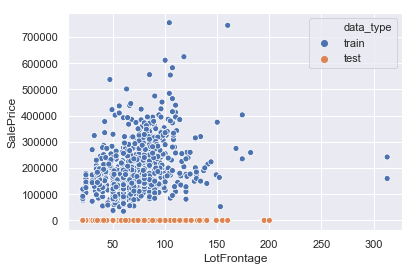

In [122]:
#### Exception case - with 310 numbers
sns.scatterplot(all_df.LotFrontage, all_df.SalePrice, hue=all_df.data_type)

In [51]:
all_df[all_df.LotFrontage>250]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
934,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,425.0,Unf,0.0,160.0,585.0,GasA,Ex,Y,SBrkr,2069,0,0,2069,1.0,0.0,2,0,4,1,Gd,9,Typ,1,Gd,Attchd,1960.0,RFn,2.0,505.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000,train
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,train


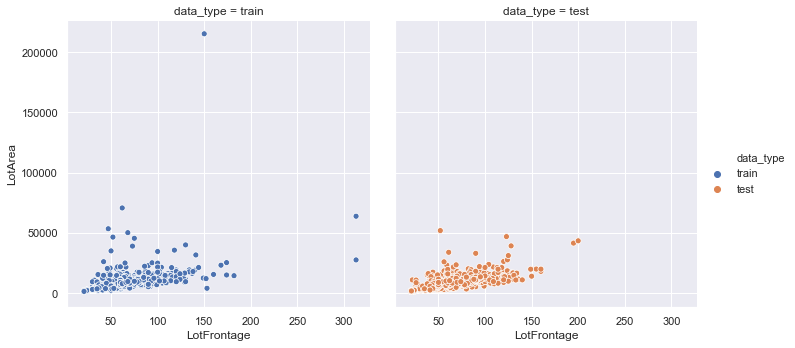

In [128]:
sns.relplot(data = all_df, x = "LotFrontage", y = "LotArea", col="data_type", hue="data_type",kind="scatter")

In [55]:
all_df[all_df.LotArea>60000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
249,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697.0,Unf,0.0,747.0,1444.0,GasA,Gd,Y,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2.0,389.0,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000,train
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236.0,Rec,820.0,80.0,2136.0,GasW,TA,Y,SBrkr,2036,0,0,2036,2.0,0.0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2.0,513.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000,train
335,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249.0,BLQ,147.0,103.0,1499.0,GasA,Ex,Y,SBrkr,1619,167,0,1786,2.0,0.0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2.0,529.0,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950,train
451,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655.0,Unf,0.0,878.0,1533.0,GasA,TA,Y,SBrkr,1533,0,0,1533,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2.0,576.0,TA,TA,Y,200,54,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000,train
706,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219.0,Unf,0.0,424.0,1643.0,GasA,TA,Y,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2.0,739.0,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000,train
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,train


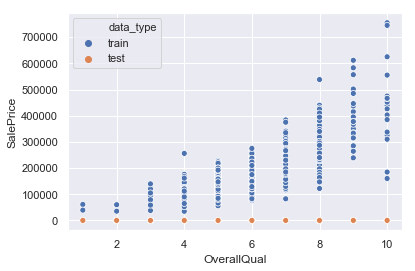

In [129]:
sns.scatterplot(all_df.OverallQual, all_df.SalePrice, hue=all_df.data_type)

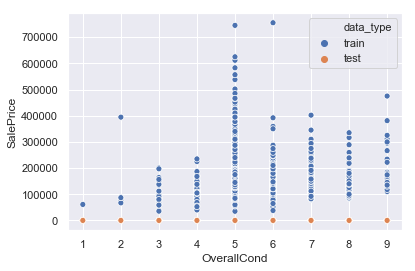

In [130]:
sns.scatterplot(all_df.OverallCond, all_df.SalePrice, hue=all_df.data_type)

In [70]:
#### Exception case
train[(train.OverallCond==2) &( train.SalePrice>300000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,2,2010,2010,Hip,CompShg,VinylSd,VinylSd,Stone,350.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1445,Unf,0,411,1856,GasA,Ex,Y,SBrkr,1856,0,0,1856,1,0,1,1,1,1,Ex,8,Typ,1,Ex,Attchd,2010.0,Fin,3,834,TA,TA,Y,113,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432,train


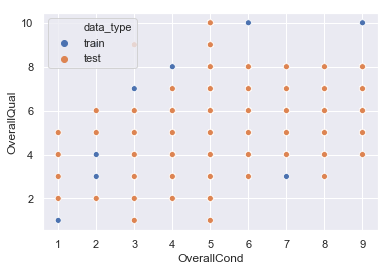

In [131]:
sns.scatterplot(all_df.OverallCond, all_df.OverallQual, hue=all_df.data_type)

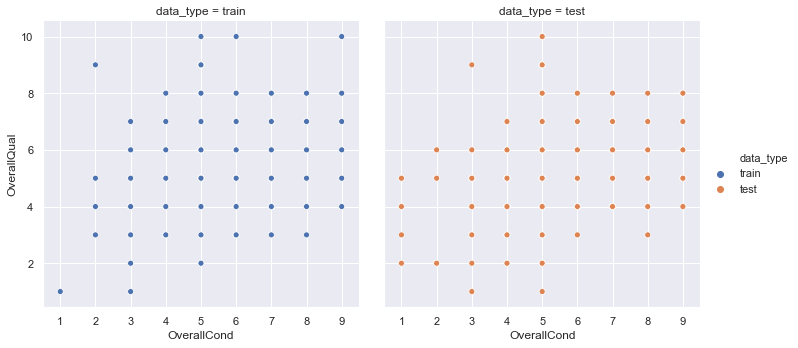

In [132]:
### Too many condition 1 items in test set
sns.relplot(data = all_df, x = "OverallCond", y = "OverallQual", col="data_type", hue="data_type",kind="scatter")

In [72]:
train[(train.OverallCond==1) &( train.OverallQual==1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
376,30,RL,NaN,10020,Pave,NaN,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,Gd,N,FuseA,904,0,0,904,1,0,0,1,1,1,Fa,4,Maj1,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal,61000,train


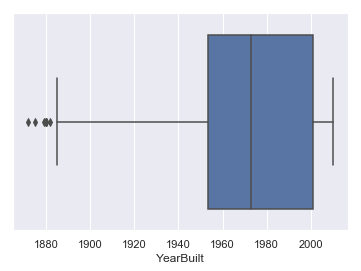

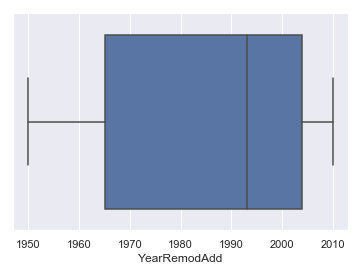

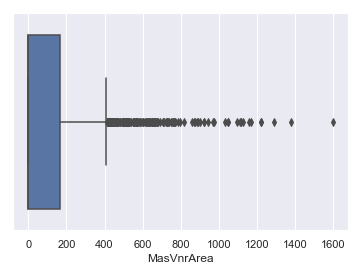

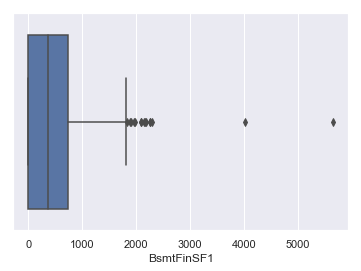

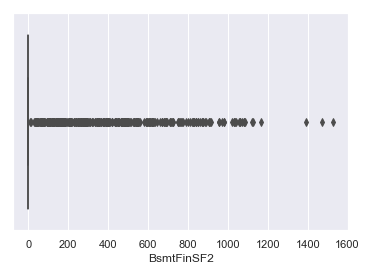

In [73]:
for i in ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']:
#        ',
#        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
#        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()



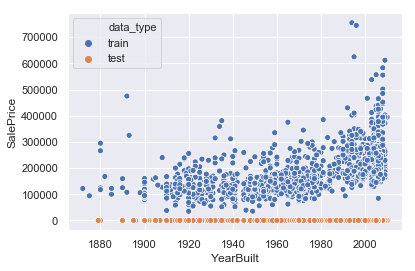

In [135]:
sns.scatterplot(all_df.YearBuilt, all_df.SalePrice, hue=all_df.data_type)

In [76]:
### Nothing odd here
train[(train.YearBuilt<=1900) &( train.SalePrice>=250000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000,train
305,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,1880,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1470,1470,GasA,Ex,Y,SBrkr,1675,1818,0,3493,0,0,3,0,3,1,Gd,10,Typ,1,Ex,Attchd,2003.0,Unf,3,870,TA,TA,Y,302,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000,train
584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Ex,Ex,BrkTil,TA,TA,No,Unf,0,Unf,0,1237,1237,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0,0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.0,Unf,2,880,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000,train
748,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,7,1880,2003,Mansard,CompShg,Stucco,Stucco,None,0.0,Gd,TA,Stone,TA,Fa,No,Unf,0,Unf,0,1240,1240,GasW,TA,N,SBrkr,1320,1320,0,2640,0,0,1,1,4,1,Gd,8,Typ,1,Gd,Detchd,1950.0,Unf,4,864,TA,TA,N,181,0,386,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979,train


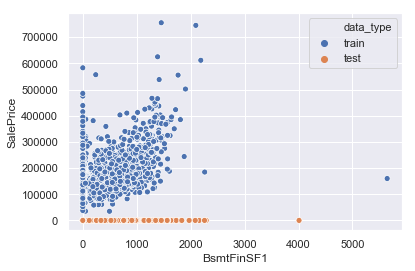

In [134]:
sns.scatterplot(all_df.BsmtFinSF1, all_df.SalePrice, hue=all_df.data_type)

In [79]:
### Something totally wrong with this - too big a house and new one for 160K
train[(train.BsmtFinSF1>=3000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,train


In [228]:
train[(train.BsmtFinSF1>=2200)].BsmtFinSF1

Id
524     2260
1299    5644
Name: BsmtFinSF1, dtype: int64

In [138]:
test[(test.BsmtFinSF1>=3000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,data_type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,2007,New,Partial,test,0


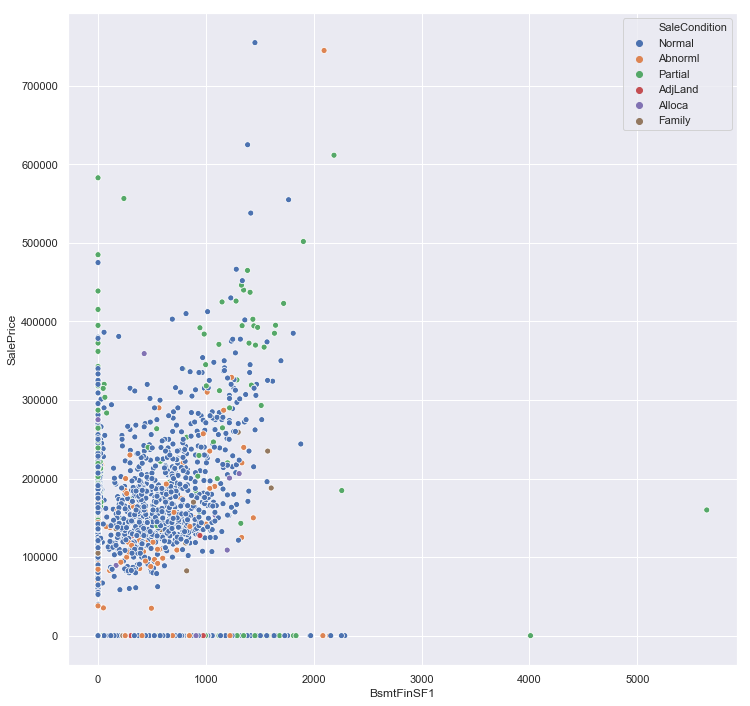

In [137]:
plt.figure(figsize=(12,12))
sns.scatterplot(all_df.BsmtFinSF1, all_df.SalePrice, hue=all_df.SaleCondition)

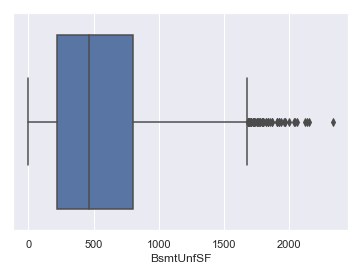

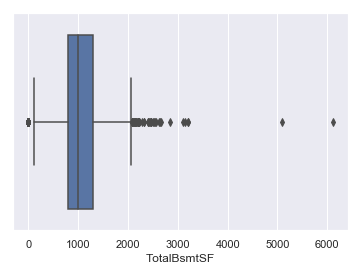

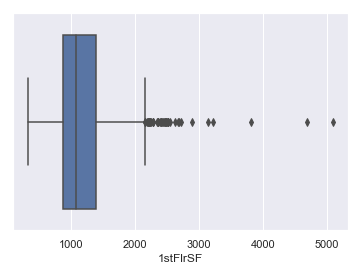

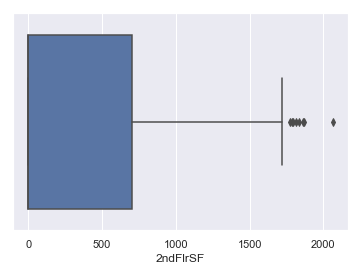

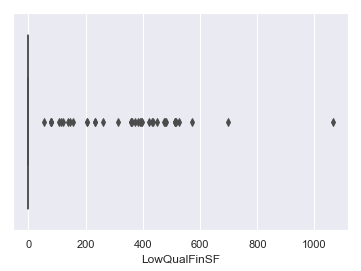

In [77]:
for i in ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']:
#        ',
#        ,
#        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

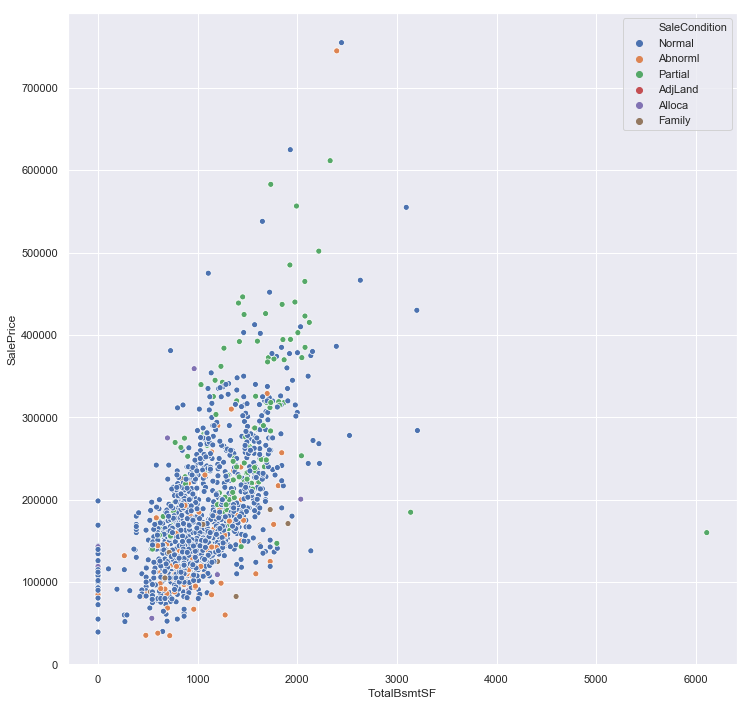

In [84]:
plt.figure(figsize=(12,12))
sns.scatterplot(train.TotalBsmtSF, train.SalePrice, hue=train.SaleCondition)

In [85]:
train[(train.TotalBsmtSF>=4000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,train


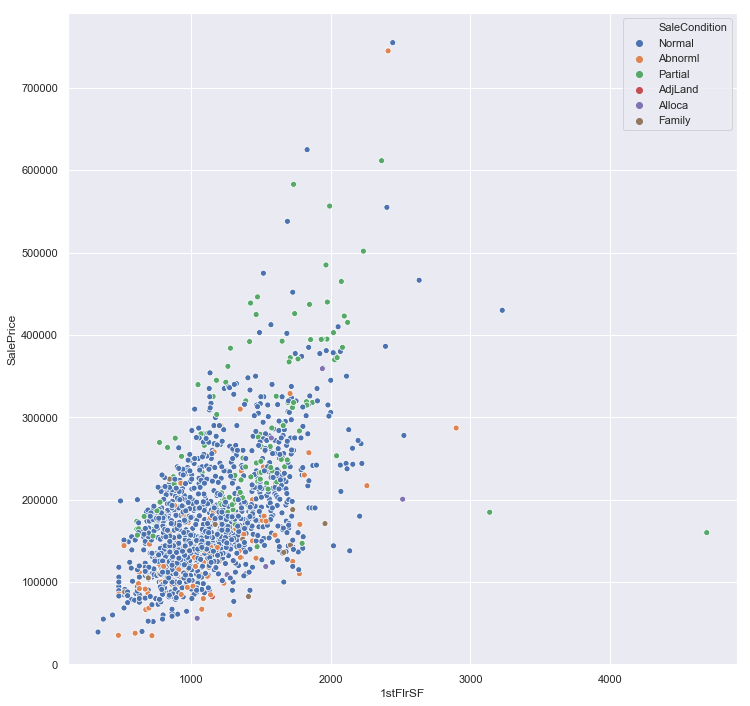

In [88]:
plt.figure(figsize=(12,12))
sns.scatterplot(train["1stFlrSF"], train.SalePrice, hue=train.SaleCondition)

In [90]:
train[(train["1stFlrSF"]>=4000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,train


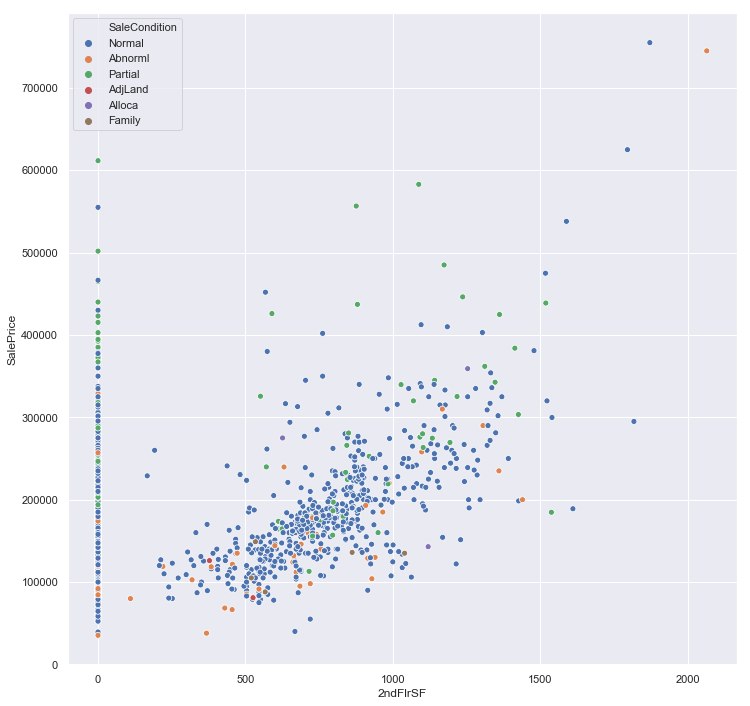

In [92]:
#### Exception : Very few values - remove the column
plt.figure(figsize=(12,12))
sns.scatterplot(train["2ndFlrSF"], train.SalePrice, hue=train.SaleCondition)

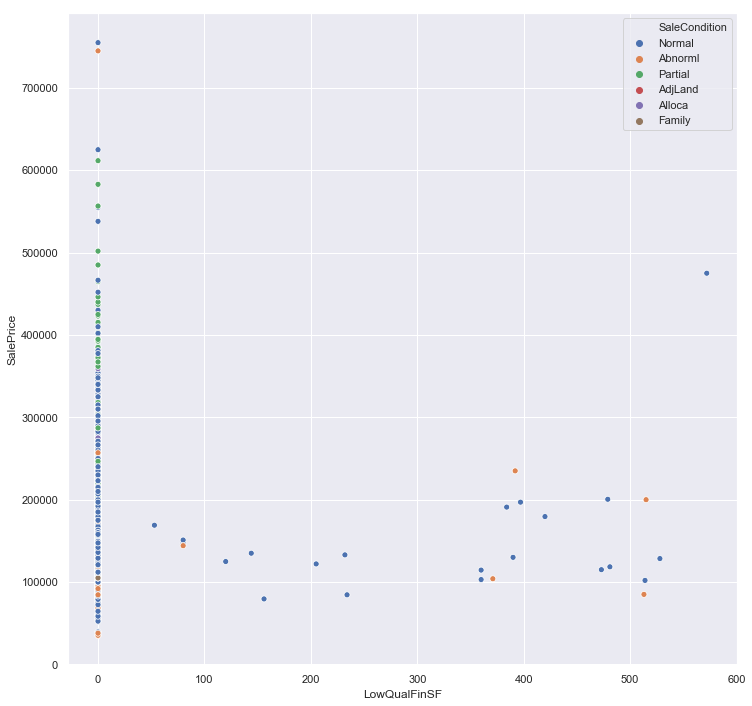

In [93]:
plt.figure(figsize=(12,12))
sns.scatterplot(train.LowQualFinSF, train.SalePrice, hue=train.SaleCondition)

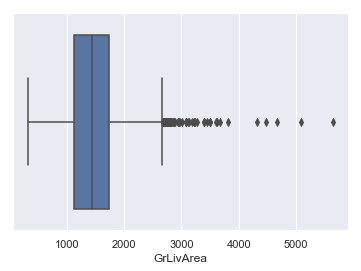

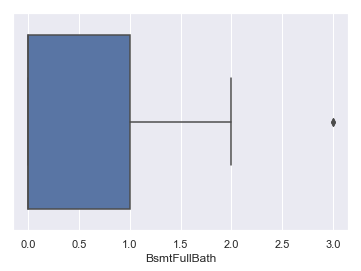

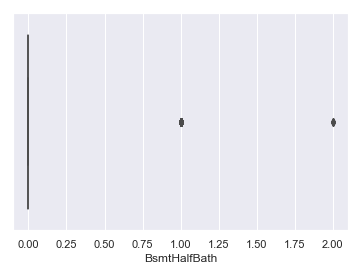

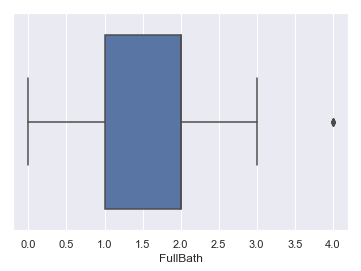

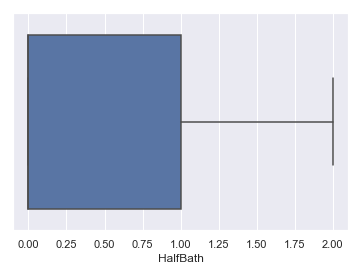

In [94]:
for i in ['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']:
#        ',
#        ,
#        ,
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

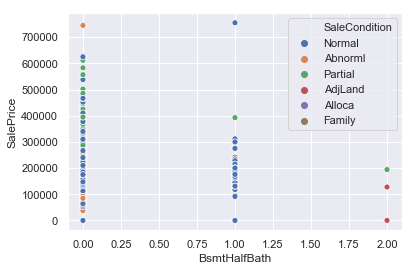

In [140]:
sns.scatterplot(all_df.BsmtHalfBath, all_df.SalePrice, hue=all_df.SaleCondition)

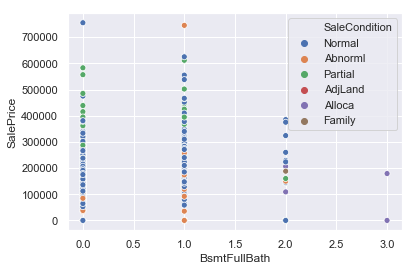

In [141]:
sns.scatterplot(all_df.BsmtFullBath, all_df.SalePrice, hue=all_df.SaleCondition)

In [98]:
### Exception
train[(train.BsmtFullBath==3)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,Gd,Gd,GLQ,1200,Unf,0,0,1200,GasA,TA,Y,SBrkr,1200,0,0,1200,3,0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000,train


In [111]:
all_df[(all_df.BsmtFullBath==3)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
738,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,Gd,Gd,GLQ,1200.0,Unf,0.0,0.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3.0,0.0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000,train
1839,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,Gd,Gd,Gd,GLQ,1200.0,Unf,0.0,0.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3.0,0.0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,0,test


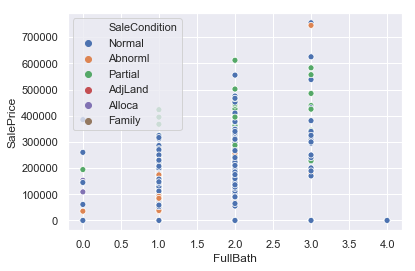

In [142]:
sns.scatterplot(all_df.FullBath, all_df.SalePrice, hue=all_df.SaleCondition)

In [112]:
### Exception - combine the bathroom count
### Seems duplexes have bathrooms in basement
### All in test data
all_df[(all_df.FullBath==4)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
1619,90,RL,70.0,7700,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,2Story,5,2,1985,1986,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Po,PConc,TA,TA,No,Unf,0.0,Unf,0.0,1216.0,1216.0,GasA,Gd,Y,SBrkr,1216,1216,0,2432,0.0,0.0,4,2,4,2,TA,10,Typ,0,NaN,Attchd,1985.0,Unf,2.0,616.0,TA,Fa,Y,200,0,0,0,0,0,NaN,NaN,Shed,600,2,2010,WD,Normal,0,test
1861,90,RL,NaN,11855,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0,test
1862,90,RL,NaN,7939,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0,test
1863,90,RL,NaN,7976,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0,test


In [114]:
all_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000,train
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000,train
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,train
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,train
9,190,

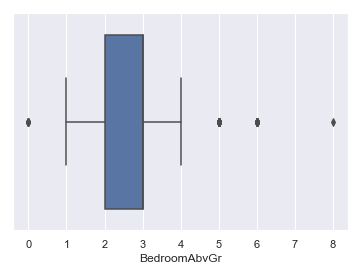

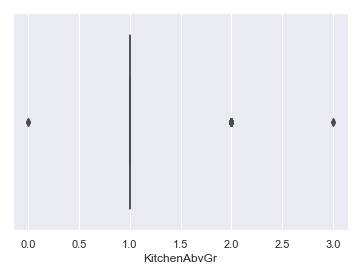

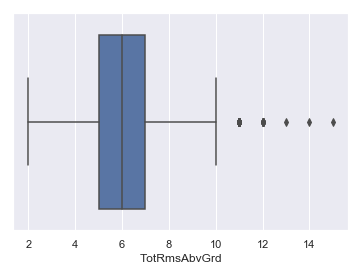

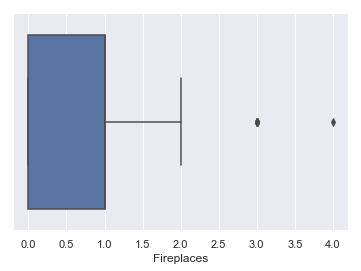

In [144]:
for i in ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']:
#        ',
#        ,
#        ,
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

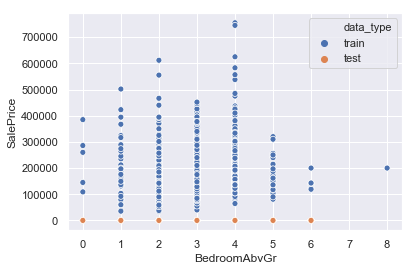

In [118]:
sns.scatterplot(all_df.BedroomAbvGr, all_df.SalePrice, hue=all_df.data_type)

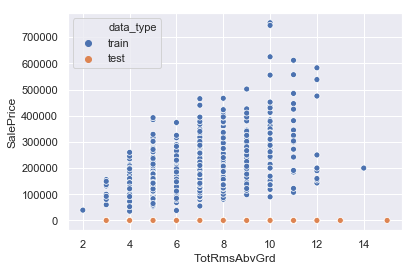

In [120]:
sns.scatterplot(all_df.TotRmsAbvGrd, all_df.SalePrice, hue=all_df.data_type)

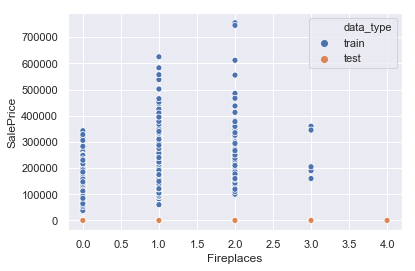

In [145]:
### Exception 4 fire places in test data
sns.scatterplot(all_df.Fireplaces, all_df.SalePrice, hue=all_df.data_type)

In [146]:
all_df[(all_df.Fireplaces==4)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
2710,80,RL,100.0,14330,Pave,NaN,IR1,Low,AllPub,Corner,Gtl,Veenker,Norm,Norm,1Fam,SLvl,7,4,1974,1974,Gable,CompShg,WdShing,Wd Sdng,BrkFace,145.0,Gd,Fa,CBlock,Gd,TA,Gd,ALQ,1023.0,BLQ,497.0,228.0,1748.0,GasA,Gd,Y,SBrkr,2151,495,0,2646,1.0,2.0,2,0,3,1,Gd,9,Mod,4,TA,Attchd,1974.0,RFn,2.0,550.0,TA,TA,Y,641,100,0,0,0,800,Gd,GdPrv,NaN,0,1,2006,WD,Normal,0,test


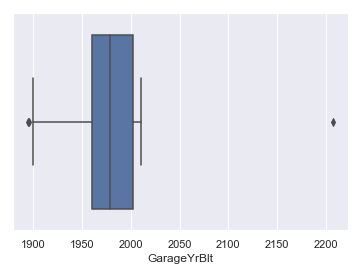

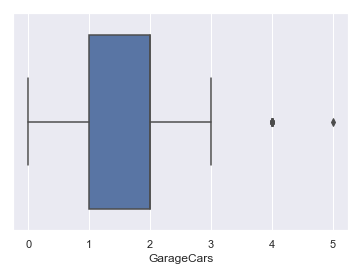

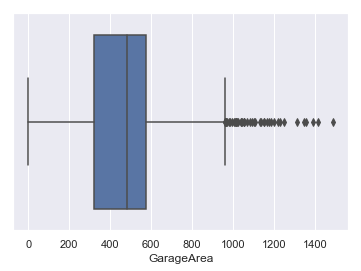

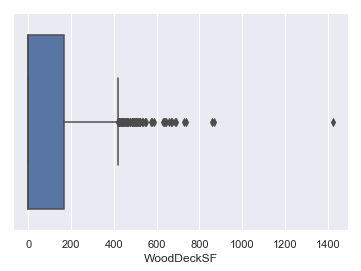

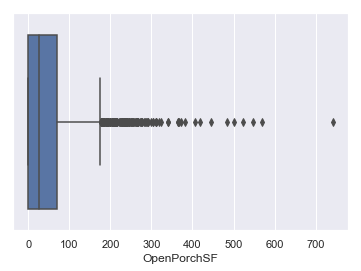

In [148]:
for i in ['GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']:
#        ',
#        ,
#        ,
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        ',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

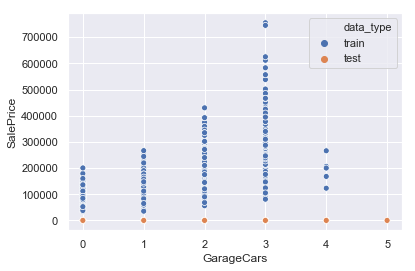

In [153]:
sns.scatterplot(all_df.GarageCars, all_df.SalePrice, hue=all_df.data_type)

In [154]:
### Exception
all_df[(all_df.GarageCars==5)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
1828,30,RM,50.0,8635,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,5,5,1925,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,BrkTil,TA,TA,No,LwQ,134.0,Unf,0.0,938.0,1072.0,GasA,TA,Y,SBrkr,1072,0,0,1072,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1982.0,Unf,5.0,1184.0,Fa,TA,P,0,0,105,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,0,test


In [155]:
### Too many test cases with 4 garages
all_df[(all_df.GarageCars==4)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
420,90,RM,78.0,7060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,SFoyer,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,200.0,TA,Gd,PConc,Gd,Gd,Gd,GLQ,1309.0,Unf,0.0,35.0,1344.0,GasA,Ex,Y,SBrkr,1344,0,0,1344,2.0,0.0,2,0,2,2,TA,8,Typ,0,NaN,Attchd,1997.0,Fin,4.0,784.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Alloca,206300,train
747,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,7,1880,2003,Mansard,CompShg,Stucco,Stucco,None,0.0,Gd,TA,Stone,TA,Fa,No,Unf,0.0,Unf,0.0,1240.0,1240.0,GasW,TA,N,SBrkr,1320,1320,0,2640,0.0,0.0,1,1,4,1,Gd,8,Typ,1,Gd,Detchd,1950.0,Unf,4.0,864.0,TA,TA,N,181,0,386,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979,train
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,2fmCon,1Story,4,4,1961,1975,Gable,CompShg,MetalSd,MetalSd,Stone,149.0,TA,Gd,CBlock,TA,TA,Av,BLQ,1159.0,Unf,0.0,90.0,1249.0,GasA,Ex,Y,SBrkr,1622,0,0,1622,1.0,0.0,1,0,3,1,TA,7,Typ,1,TA,2Types,1975.0,Fin,4.0,1356.0,TA,TA,Y,439,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000,train
1340,20,RL,70.0,8294,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,858.0,858.0,GasA,TA,Y,SBrkr,872,0,0,872,0.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1974.0,Unf,4.0,480.0,TA,TA,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,123000,train
1350,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,Duplex,2Story,5,5,1969,1969,Gable,CompShg,MetalSd,MetalSd,BrkFace,368.0,TA,TA,CBlock,TA,TA,No,LwQ,500.0,Unf,0.0,748.0,1248.0,GasA,TA,Y,SBrkr,1338,1296,0,2634,1.0,1.0,2,2,6,2,TA,12,Typ,0,NaN,Detchd,1969.0,Unf,4.0,968.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000,train
1575,60,RL,87.0,12361,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,6,7,1993,1993,Gable,CompShg,VinylSd,VinylSd,BrkFace,85.0,Gd,Gd,PConc,Gd,TA,No,GLQ,860.0,Unf,0.0,86.0,946.0,GasA,Ex,Y,SBrkr,964,838,0,1802,0.0,1.0,2,1,3,1,Gd,8,Typ,1,Gd,2Types,2000.0,RFn,4.0,1017.0,TA,TA,Y,450,92,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,0,test
1861,90,RL,NaN,11855,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0,test
1862,90,RL,NaN,7939,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0,test
1863,90,RL,NaN,7976,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0,te

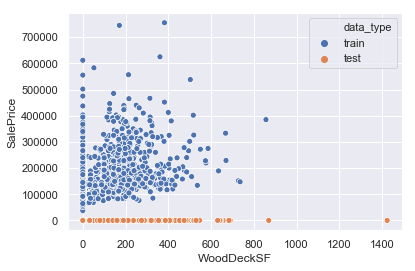

In [159]:
### Exception in test 
sns.scatterplot(all_df.WoodDeckSF, all_df.SalePrice, hue=all_df.data_type)

In [162]:
all_df[(all_df.WoodDeckSF>1000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
2606,80,RL,NaN,15957,Pave,NaN,IR1,Low,AllPub,Corner,Mod,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,1148.0,Unf,0.0,96.0,1244.0,GasA,TA,Y,SBrkr,1356,0,0,1356,2.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1977.0,Fin,2.0,528.0,TA,TA,Y,1424,0,0,0,0,0,NaN,MnPrv,NaN,0,9,2007,WD,Normal,0,test


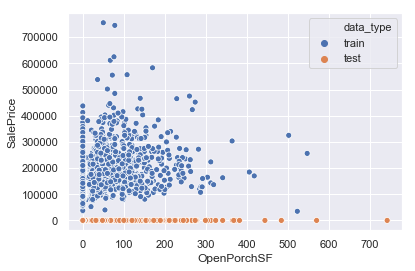

In [164]:
### Another testy exception
sns.scatterplot(all_df.OpenPorchSF, all_df.SalePrice, hue=all_df.data_type)

In [163]:
all_df[(all_df.OpenPorchSF>600)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
2557,90,RL,60.0,10890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,Duplex,2Story,5,6,1923,1950,Hip,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,371.0,Unf,0.0,925.0,1296.0,Grav,Fa,N,FuseA,1296,1296,0,2592,2.0,0.0,2,0,6,2,TA,12,Min2,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,742,240,0,0,0,NaN,NaN,Shed,1512,1,2007,WD,AdjLand,0,test


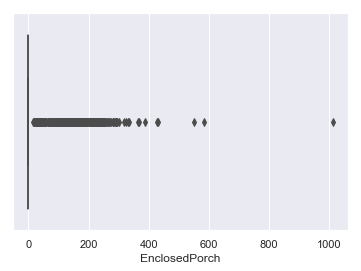

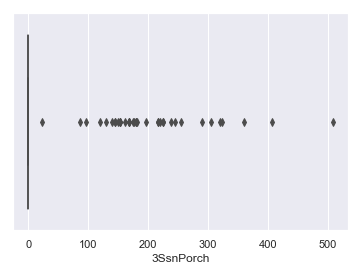

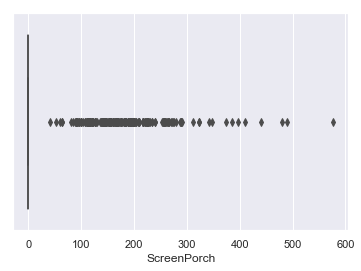

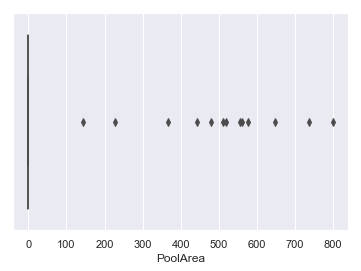

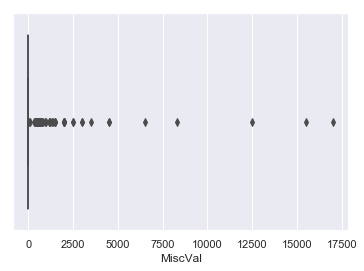

In [165]:
for i in ['EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']:

#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

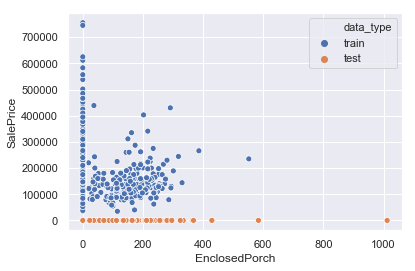

In [166]:
sns.scatterplot(all_df.EnclosedPorch, all_df.SalePrice, hue=all_df.data_type)

In [167]:
### Exceptions in test
all_df[(all_df.EnclosedPorch>600)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
2503,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal,0,test


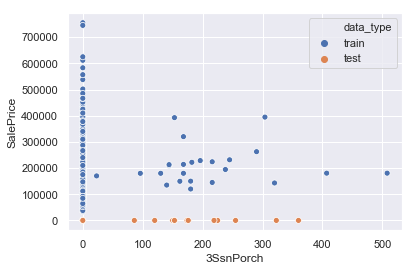

In [170]:
sns.scatterplot(all_df["3SsnPorch"], all_df.SalePrice, hue=all_df.data_type)

In [171]:
all_df[(all_df["3SsnPorch"]>400)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
55,20,RL,100.0,10175,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1964,1964,Gable,CompShg,HdBoard,Plywood,BrkFace,272.0,TA,TA,CBlock,TA,TA,No,BLQ,490.0,Unf,0.0,935.0,1425.0,GasA,Gd,Y,SBrkr,1425,0,0,1425,0.0,0.0,2,0,3,1,TA,7,Typ,1,Gd,Attchd,1964.0,RFn,2.0,576.0,TA,TA,Y,0,0,0,407,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,180500,train
205,20,RL,99.0,11851,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1424.0,1424.0,GasA,Ex,Y,SBrkr,1442,0,0,1442,0.0,0.0,2,0,3,1,TA,5,Typ,0,NaN,Attchd,1990.0,RFn,2.0,500.0,TA,TA,Y,0,34,0,508,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,180500,train


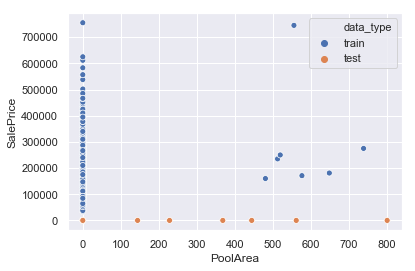

In [174]:
### Highest val in test case
### both on high side and low side
sns.scatterplot(all_df.PoolArea, all_df.SalePrice, hue=all_df.data_type)

In [173]:
all_df[(all_df.PoolArea>600)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
810,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,Fa,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000,train
1423,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,TA,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970,train
2710,80,RL,100.0,14330,Pave,NaN,IR1,Low,AllPub,Corner,Gtl,Veenker,Norm,Norm,1Fam,SLvl,7,4,1974,1974,Gable,CompShg,WdShing,Wd Sdng,BrkFace,145.0,Gd,Fa,CBlock,Gd,TA,Gd,ALQ,1023.0,BLQ,497.0,228.0,1748.0,GasA,Gd,Y,SBrkr,2151,495,0,2646,1.0,2.0,2,0,3,1,Gd,9,Mod,4,TA,Attchd,1974.0,RFn,2.0,550.0,TA,TA,Y,641,100,0,0,0,800,Gd,GdPrv,NaN,0,1,2006,WD,Normal,0,test


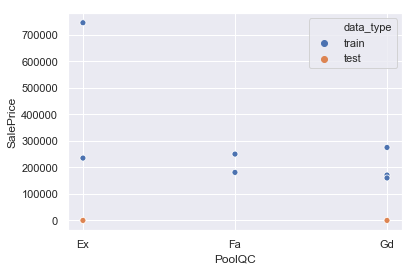

In [175]:
sns.scatterplot(all_df.PoolQC, all_df.SalePrice, hue=all_df.data_type)

In [178]:
### Exception - shud drop all pool columns and replace with Pool Y/N
all_df[all_df.PoolArea == 0].PoolArea.count()

2906

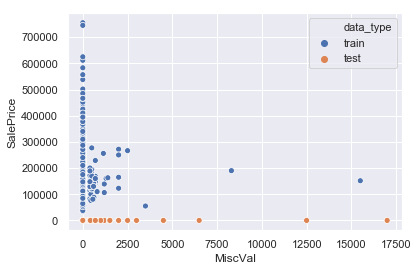

In [179]:
sns.scatterplot(all_df.MiscVal, all_df.SalePrice, hue=all_df.data_type)

In [180]:
### Get rid of this - too few values
all_df.MiscVal.value_counts()

0        2816
400        18
500        13
450         9
600         8
700         7
2000        7
650         3
1200        3
1500        3
4500        2
2500        2
480         2
3000        2
12500       1
300         1
350         1
8300        1
420         1
80          1
54          1
460         1
490         1
3500        1
560         1
17000       1
15500       1
750         1
800         1
900         1
1000        1
1150        1
1300        1
1400        1
1512        1
6500        1
455         1
620         1
Name: MiscVal, dtype: int64

In [181]:
all_df.MiscFeature.value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [182]:
all_df.shape

(2919, 81)

In [186]:
print(all_df[all_df.MiscVal != 0][["MiscVal", "MiscFeature"]])

      MiscVal MiscFeature
5         700        Shed
7         350        Shed
16        700        Shed
17        500        Shed
51        400        Shed
84        700        Shed
95        480        Shed
98        400        Shed
99        400        Shed
106       450        Shed
214       450        Shed
249       500        Shed
250       450        Shed
335       700        Shed
338       400        Shed
346     15500        Gar2
392      1200        Shed
439       800        Shed
499       480        Shed
502       400        Shed
510      2000        Shed
539      2000        Shed
589       600        Shed
611       500        Shed
626       600        Shed
634       600        Shed
705      3500        Othr
725       500        Shed
733       400        Shed
760       450        Shed
766       500        Shed
767      1300        Shed
786      1200        Shed
794       500        Shed
800       400        Shed
812        54        Shed
813       500        Shed
867       40

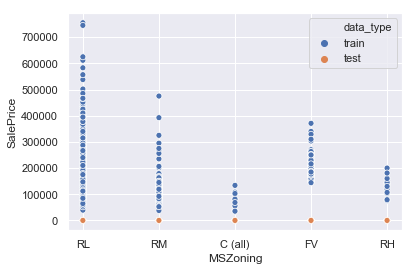

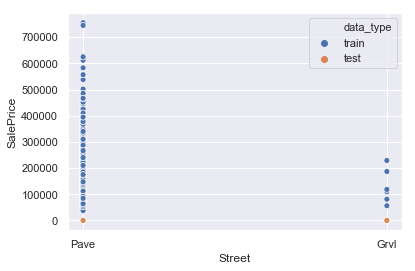

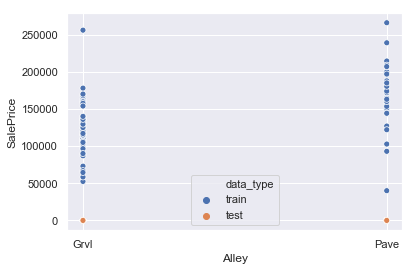

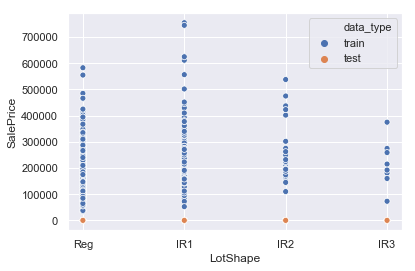

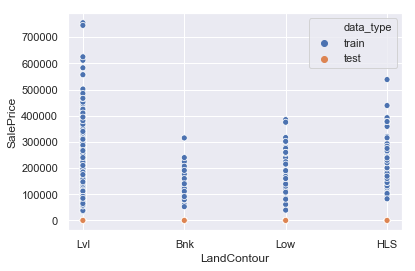

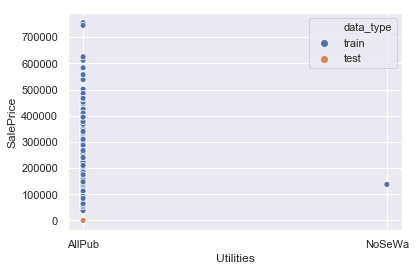

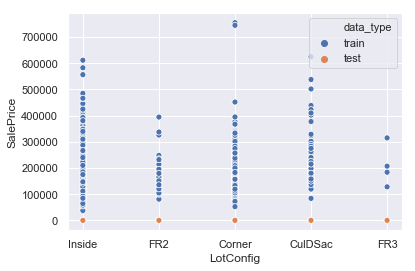

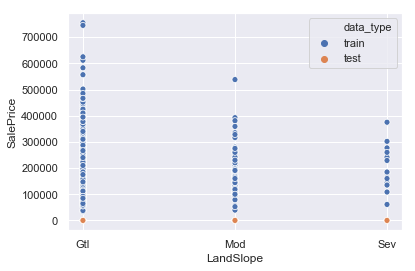

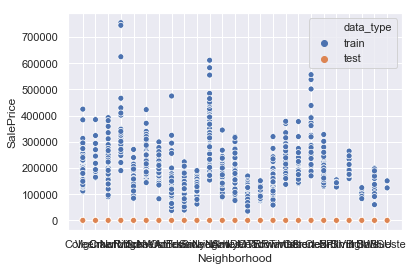

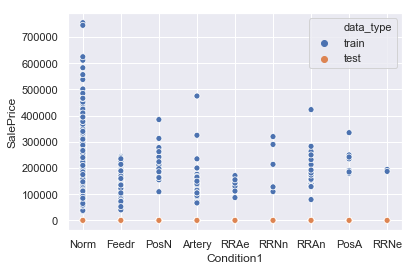

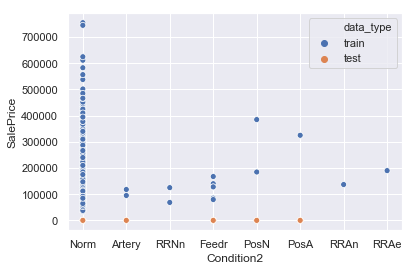

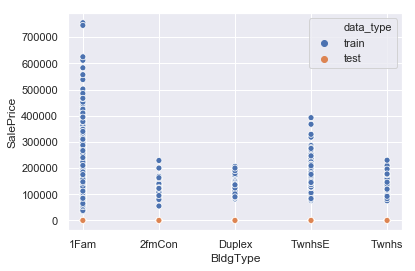

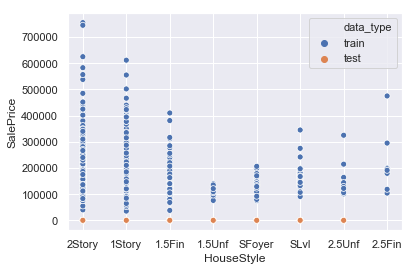

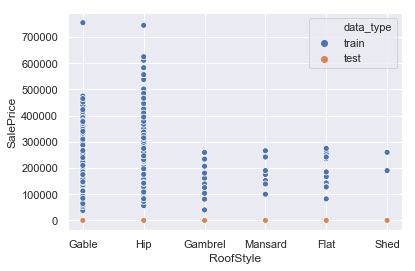

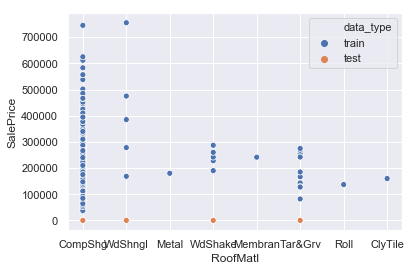

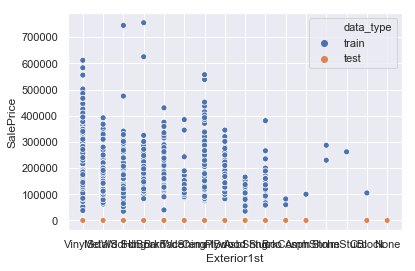

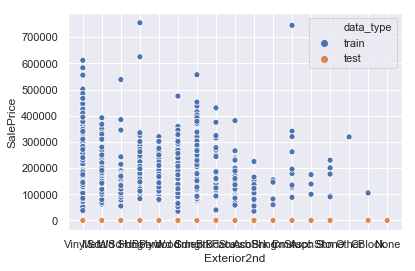

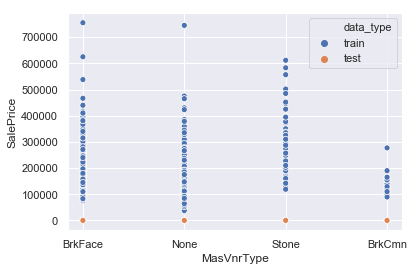

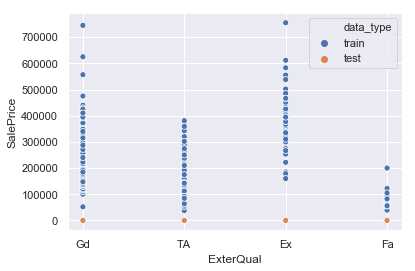

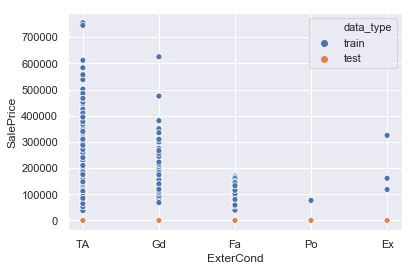

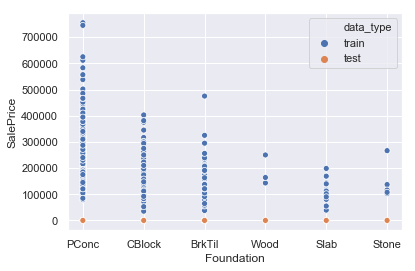

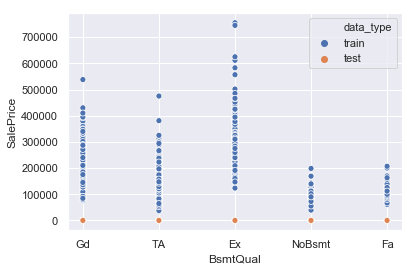

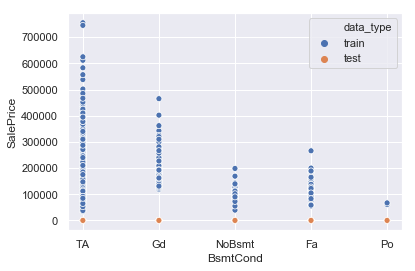

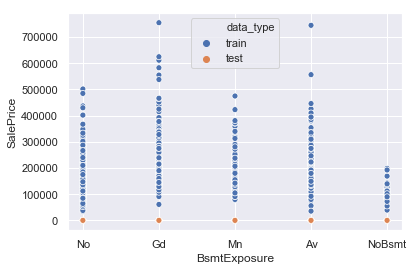

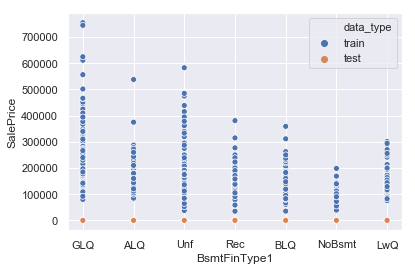

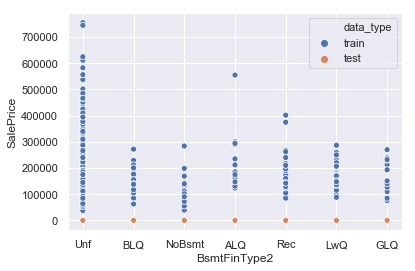

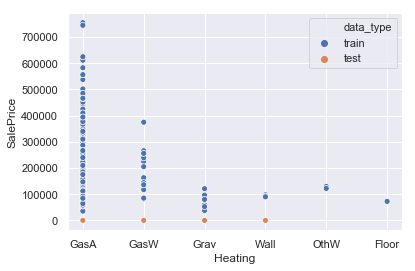

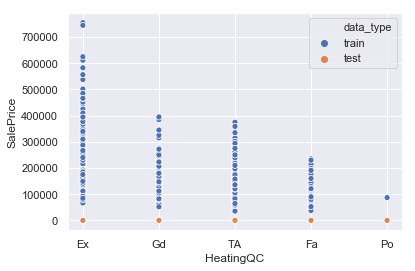

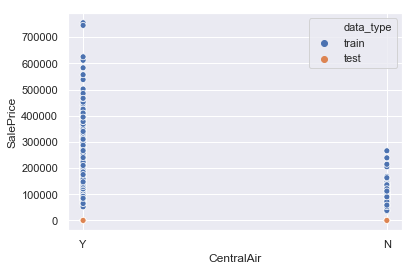

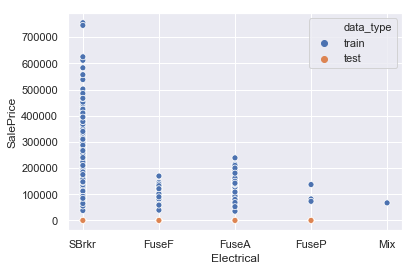

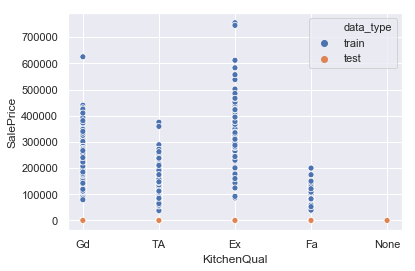

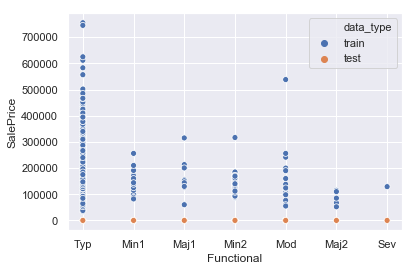

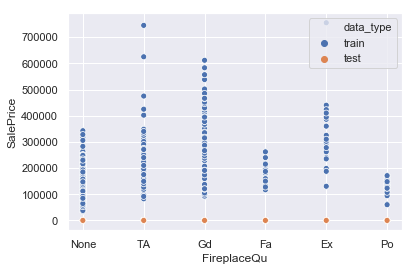

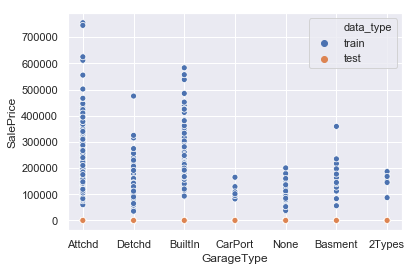

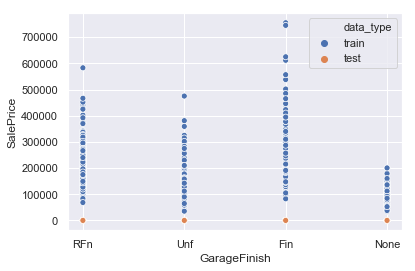

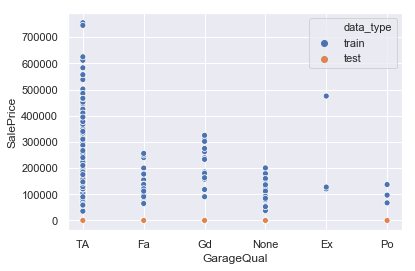

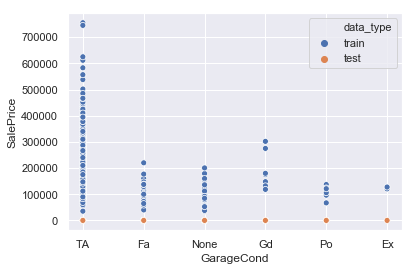

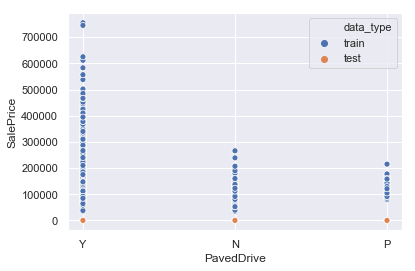

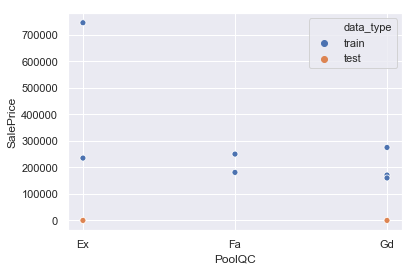

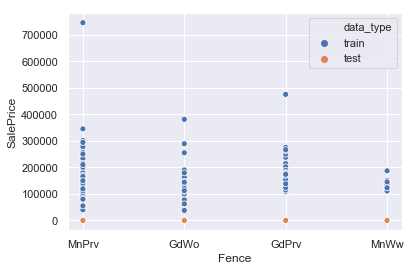

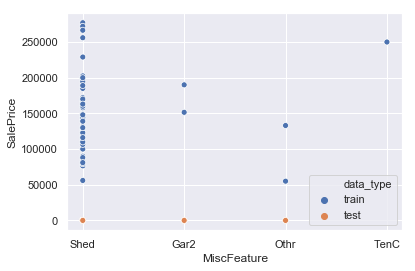

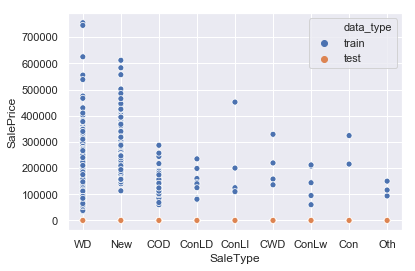

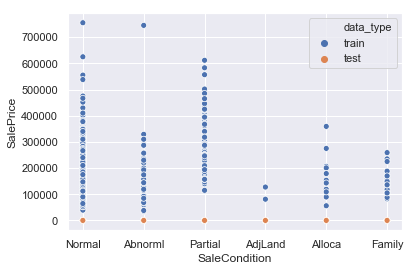

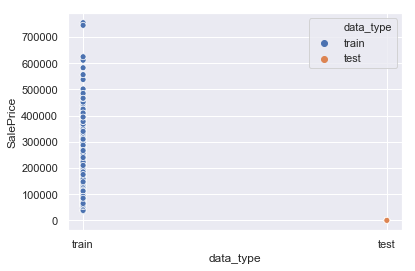

In [193]:
for i in cat_cols: 
    sns.scatterplot(fin_df[i], fin_df.SalePrice, hue=fin_df.data_type)
    
    plt.show()
    all_df.groupby("data_type")[i].value_counts()

# Trying Transformation

In [199]:
all_df["Electrical"].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [200]:
all_df["Electrical"] = np.where(all_df["Electrical"].str.contains("SBrkr"), 1, 0)

In [201]:
all_df["Electrical"].value_counts()

1    2672
0     247
Name: Electrical, dtype: int64

In [202]:
all_df["Heating"].value_counts()

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

In [203]:
all_df["Heating"] = np.where(all_df["Heating"].str.contains("GasA"), 1, 0)

In [204]:
all_df["Heating"].value_counts()

1    2874
0      45
Name: Heating, dtype: int64

In [209]:
all_df["RoofMatl"].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
ClyTile       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

In [219]:
all_df["RoofMatl"] = np.where(all_df["RoofMatl"].str.contains("CompShg|WdShngl", regex=True), True, False)

In [220]:
all_df["RoofMatl"].value_counts()

True     2883
False      36
Name: RoofMatl, dtype: int64

In [221]:
all_df["RoofMatl"].dtype

dtype('bool')

In [225]:
xx = pd.get_dummies(all_df[["RoofMatl"]])
xx.head()

,RoofMatl
0,True
1,True
2,True
3,True
4,True


In [227]:
all_df["RoofMatl"] = np.where(all_df["RoofMatl"].str.contains("CompShg|WdShngl", regex=True), "1", "0")
xx = pd.get_dummies(all_df[["RoofMatl"]])
xx.head()

,RoofMatl_0,RoofMatl_1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [226]:
train,test,all_df,fin_df = process_raw_data()



*****
 Processing raw files to generate processed files... hold tight...


*****
Loading test and train data....
Train Data Shape : (1460, 81)
Test Data Shape :  (1459, 81)
Combined Data Shape :  (2919, 81)


*****
Printing stats...
No of rows :  2919
No of columns :  81
Numeric columns :  37
Non Numeric columns :  44


Null counts :
              NA Count   PERCENT
Column                          
MSZoning           4.0  0.001370
LotFrontage      486.0  0.166495
Alley           2721.0  0.932169
Utilities          2.0  0.000685
Exterior1st        1.0  0.000343
Exterior2nd        1.0  0.000343
MasVnrType        24.0  0.008222
MasVnrArea        23.0  0.007879
BsmtQual          81.0  0.027749
BsmtCond          82.0  0.028092
BsmtExposure      82.0  0.028092
BsmtFinType1      79.0  0.027064
BsmtFinSF1         1.0  0.000343
BsmtFinType2      80.0  0.027407
BsmtFinSF2         1.0  0.000343
BsmtUnfSF          1.0  0.000343
TotalBsmtSF        1.0  0.000343
Electrical         1.0  0.000343
Bs

In [214]:
all_df["TotalFullBaths"] = all_df["BsmtFullBath"]+all_df["FullBath"]



In [216]:
all_df["TotalHalfBaths"] = all_df["BsmtHalfBath"]+all_df["HalfBath"]

